### Packages

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376171 sha256=ac228636a89868f893fbc3b488c7b80da2c515e5030c9fddb6d2e5dcc2327b7c
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
!pip install stable_baselines3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.7/181.7 kB 4.0 MB/s eta 0:00:00


# **Lunar Lander**

## **Abstract**

The Lunar Lander project aims to train an agent using reinforcement learning techniques to solve the LunarLander-v2 environment provided by OpenAI Gymnasium. The project utilizes the Tianshou library for reinforcement learning implementations. It includes utilities for logging training data, visualizing learning curves, and recording agent performance videos. The main part of the code orchestrates the training process, including setting up the environment, defining the neural network architecture, configuring the training parameters, and executing the training loop. The trained agent's performance is evaluated using learning curves and recorded videos.

## **Introduction**

The LunarLander-v2 environment simulates the task of landing a lunar module safely on the moon's surface. The agent controls the module's thrusters to adjust its position and velocity, aiming to land softly on a designated landing pad. This project tackles this problem using reinforcement learning, where the agent learns to navigate the environment through trial and error, maximizing cumulative rewards.

## **Utilities**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from stable_baselines3.common.callbacks import BaseCallback
from tqdm import tqdm
from os import listdir
from tensorflow.python.summary.summary_iterator import summary_iterator


class LogStepsCallback(BaseCallback):
    def __init__(self, log_dir, verbose=0):
        self.log_dir = log_dir
        super(LogStepsCallback, self).__init__(verbose)

    def _on_training_start(self) -> None:
        self.results = pd.DataFrame(columns=['Reward', 'Done'])
        print("Τraining starts!")

    def _on_step(self) -> bool:
        if 'reward' in self.locals:
            keys = ['reward', 'done']
        else:
            keys = ['rewards', 'dones']
        self.results.loc[len(self.results)] = [self.locals[keys[0]][0], self.locals[keys[1]][0]]
        return True

    def _on_training_end(self) -> None:
        self.results.to_csv(self.log_dir + 'training_data.csv', index=False)
        print("Τraining ends!")


class TqdmCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.progress_bar = None

    def _on_training_start(self):
        self.progress_bar = tqdm(total=self.locals['total_timesteps'])

    def _on_step(self):
        self.progress_bar.update(1)
        return True

    def _on_training_end(self):
        self.progress_bar.close()
        self.progress_bar = None


def save_dict_to_file(dict, path, txt_name='hyperparameter_dict'):
    f = open(path + '/' + txt_name + '.txt', 'w')
    f.write(str(dict))
    f.close()


def calc_episode_rewards(training_data):
    # Calculate the rewards for each training episode
    episode_rewards = []
    temp_reward_sum = 0

    for step in range(training_data.shape[0]):
        reward, done = training_data.iloc[step, :]
        temp_reward_sum += reward
        if done:
            episode_rewards.append(temp_reward_sum)
            temp_reward_sum = 0

    result = pd.DataFrame(columns=['Reward'])
    result['Reward'] = episode_rewards
    return result


def learning_curve(episode_rewards, log_dir, window=10):
    # Calculate rolling window metrics
    rolling_average = episode_rewards.rolling(window=window, min_periods=window).mean().dropna()
    rolling_max = episode_rewards.rolling(window=window, min_periods=window).max().dropna()
    rolling_min = episode_rewards.rolling(window=window, min_periods=window).min().dropna()

    # Change column name
    rolling_average.columns = ['Average Reward']
    rolling_max.columns = ['Max Reward']
    rolling_min.columns = ['Min Reward']
    rolling_data = pd.concat([rolling_average, rolling_max, rolling_min], axis=1)

    # Plot
    sns.set()
    ax = sns.lineplot(data=rolling_data)
    ax.fill_between(rolling_average.index, rolling_min.iloc[:, 0], rolling_max.iloc[:, 0], alpha=0.2)
    ax.set_title('Learning Curve')
    ax.set_ylabel('Reward')
    ax.set_xlabel('Episodes')
    ax.set(ylim=(-250, 325))

    # Save figure
    plt.savefig(log_dir + 'learning_curve' + str(window) + '.png')


def learning_curve_baselines(log_dir, window=10):
    # Read data
    training_data = pd.read_csv(log_dir + 'training_data.csv', index_col=None)

    # Calculate episode rewards
    episode_rewards = calc_episode_rewards(training_data)

    learning_curve(episode_rewards=episode_rewards, log_dir=log_dir, window=window)


def learning_curve_tianshou(log_dir, window=10):
    # Find event file
    files = listdir(log_dir)
    for f in files:
        if 'events' in f:
            event_file = f
            break

    # Read episode rewards
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])
    try:
        for e in summary_iterator(log_dir + event_file):
            if len(e.summary.value) > 0:
                if e.summary.value[0].tag == 'train/reward':
                    episode_rewards_list.append(e.summary.value[0].simple_value)
    except Exception as e:
        pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)


def learning_curve_tianshou_multiple_runs(log_dirs, window=10):
    episode_rewards_list = []
    episode_rewards = pd.DataFrame(columns=['Reward'])

    for log_dir in log_dirs:
        # Find event file
        files = listdir(log_dir)
        for f in files:
            if 'events' in f:
                event_file = f
                break

        # Read episode rewards

        try:
            for e in summary_iterator(log_dir + event_file):
                if len(e.summary.value) > 0:
                    if e.summary.value[0].tag == 'train/reward':
                        episode_rewards_list.append(e.summary.value[0].simple_value)
        except Exception as e:
            pass
    episode_rewards['Reward'] = episode_rewards_list

    # Learning curve
    learning_curve(episode_rewards, log_dir, window=window)

The utilities section of the Lunar Lander project encompasses several functions and callback classes essential for managing and analyzing the reinforcement learning training process. Here's a breakdown of each component:

1. **LogStepsCallback**:

This callback class is responsible for logging training rewards and episode completion status during the training process. It captures reward values and whether an episode is done at each training step and stores them in a Pandas DataFrame. Upon training completion, it saves the training data to a CSV file.

2. **TqdmCallback**:

  This callback class integrates a progress bar using the tqdm library to track the training progress. It displays the progress bar during training, updating it with each training step.

3. **save_dict_to_file**:

  This function enables saving dictionaries to text files. It takes a dictionary, a file path, and an optional text file name as input, converting the dictionary to a string representation and writing it to a text file.

4. **calc_episode_rewards**:

  This function calculates the cumulative rewards for each training episode based on the training data. It iterates through the training data, summing up rewards until an episode is complete, then resets the reward sum for the next episode.

5. **learning_curve**:

  This function generates and saves learning curve plots based on episode rewards. It calculates rolling window metrics such as the average, maximum, and minimum rewards over a specified window size, then plots these metrics over episodes, providing insights into the training progress.

6. **learning_curve_baselines**:

  This function generates learning curves from training data using baselines. It reads training data from a CSV file, calculates episode rewards, and calls the learning_curve function to plot and save the learning curve.

7. **learning_curve_tianshou**:

  This function generates learning curves from training data using the Tianshou library. It reads episode rewards from event files generated during training, constructs a DataFrame, and calls the learning_curve function to plot and save the learning curve.

8. **learning_curve_tianshou_multiple_runs**:

  This function generates learning curves from multiple runs of Tianshou training. It iterates through directories containing event files from multiple runs, aggregates episode rewards, and calls the learning_curve function to plot and save the learning curve.

### More packages

In [ ]:
!pip install tianshou

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.1/163.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 847.8/847.8 kB 52.5 MB/s eta 0:00:00


In [ ]:
import time
from gymnasium import wrappers
import gymnasium as gym
import tianshou as ts
import torch
import numpy as np
from torch.utils.tensorboard import SummaryWriter
from tianshou.utils import TensorboardLogger
import torch
from tianshou.utils.net.common import Net

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Another one

In [ ]:
!pip install shimmy

## **More information about Lunar-Lander-v2**

It navigates the lander to its landing pad. The landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

## **Main**

Using: cuda:0
Epoch = 0
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video0/eval-episode-0.mp4



/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video3/eval-episode-0.mp4


Epoch #1: 100001it [13:11, 126.40it/s, env_step=100000, len=277, loss=49.115, n/ep=0, n/st=5, rew=43.30]                            


Epoch = 1
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_1/video3/eval-episode-0.mp4
Epoch #1: test_reward: 63.530472 ± 192.361309, best_reward: 63.530472 ± 192.361309 in #1


Epoch #2: 100001it [12:51, 129.70it/s, env_step=200000, len=428, loss=33.096, n/ep=0, n/st=5, rew=195.53]                            


Epoch = 2
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_2/video3/eval-episode-0.mp4
Epoch #2: test_reward: 85.695488 ± 174.845041, best_reward: 85.695488 ± 174.845041 in #2


Epoch #3: 100001it [12:55, 128.89it/s, env_step=300000, len=114, loss=38.753, n/ep=0, n/st=5, rew=16.46]                            


Epoch = 3
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_3/video3/eval-episode-0.mp4
Epoch #3: test_reward: 236.428035 ± 74.427672, best_reward: 236.428035 ± 74.427672 in #3


Epoch #4: 100001it [12:21, 134.90it/s, env_step=400000, len=997, loss=34.933, n/ep=0, n/st=5, rew=220.27]                            


Epoch = 4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_4/video3/eval-episode-0.mp4
Epoch #4: test_reward: 176.752802 ± 82.657687, best_reward: 236.428035 ± 74.427672 in #3


Epoch #5: 100001it [12:10, 136.98it/s, env_step=500000, len=259, loss=47.359, n/ep=0, n/st=5, rew=-190.19]                            


Epoch = 5
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video3/eval-episode-0.mp4
Epoch #5: test_reward: 243.341500 ± 34.913760, best_reward: 243.341500 ± 34.913760 in #5


Epoch #6: 100001it [12:16, 135.73it/s, env_step=600000, len=249, loss=36.782, n/ep=0, n/st=5, rew=270.77]                            


Epoch = 6
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_6/video3/eval-episode-0.mp4
Epoch #6: test_reward: 207.604551 ± 61.022276, best_reward: 243.341500 ± 34.913760 in #5


Epoch #7: 100001it [11:57, 139.30it/s, env_step=700000, len=162, loss=36.030, n/ep=0, n/st=5, rew=256.41]


Epoch = 7
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_7/video3/eval-episode-0.mp4
Epoch #7: test_reward: 228.489572 ± 104.764380, best_reward: 243.341500 ± 34.913760 in #5


Epoch #8: 100001it [11:57, 139.33it/s, env_step=800000, len=151, loss=29.932, n/ep=0, n/st=5, rew=252.93]                            


Epoch = 8
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_8/video3/eval-episode-0.mp4
Epoch #8: test_reward: 281.007235 ± 15.354798, best_reward: 281.007235 ± 15.354798 in #8


Epoch #9: 100001it [11:51, 140.61it/s, env_step=900000, len=146, loss=30.501, n/ep=0, n/st=5, rew=290.99]                            


Epoch = 9
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_9/video3/eval-episode-0.mp4
Epoch #9: test_reward: 273.386739 ± 14.751761, best_reward: 281.007235 ± 15.354798 in #8


Epoch #10: 100001it [11:46, 141.63it/s, env_step=1000000, len=188, loss=25.397, n/ep=0, n/st=5, rew=290.53]                            


Epoch = 10
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video3/eval-episode-0.mp4
Epoch #10: test_reward: 285.794522 ± 15.273176, best_reward: 285.794522 ± 15.273176 in #10


Epoch #11: 100001it [11:48, 141.21it/s, env_step=1100000, len=224, loss=23.116, n/ep=0, n/st=5, rew=299.02]                            


Epoch = 11
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_11/video3/eval-episode-0.mp4
Epoch #11: test_reward: 280.858002 ± 15.406816, best_reward: 285.794522 ± 15.273176 in #10


Epoch #12: 100001it [11:48, 141.16it/s, env_step=1200000, len=155, loss=26.207, n/ep=0, n/st=5, rew=269.57]                            


Epoch = 12
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_12/video3/eval-episode-0.mp4
Epoch #12: test_reward: 282.681551 ± 20.815698, best_reward: 285.794522 ± 15.273176 in #10


Epoch #13: 100001it [11:40, 142.76it/s, env_step=1300000, len=158, loss=34.293, n/ep=0, n/st=5, rew=272.11]                            


Epoch = 13
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video3/eval-episode-0.mp4
Epoch #13: test_reward: 287.625486 ± 14.655282, best_reward: 287.625486 ± 14.655282 in #13


Epoch #14: 100001it [11:55, 139.68it/s, env_step=1400000, len=190, loss=33.722, n/ep=0, n/st=5, rew=292.49]                            


Epoch = 14
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_14/video3/eval-episode-0.mp4
Epoch #14: test_reward: 283.952697 ± 12.908026, best_reward: 287.625486 ± 14.655282 in #13


Epoch #15: 100001it [11:56, 139.58it/s, env_step=1500000, len=137, loss=20.360, n/ep=0, n/st=5, rew=269.66]                            


Epoch = 15
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video0/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video3/eval-episode-0.mp4
Epoch #15: test_reward: 273.420183 ± 45.720027, best_reward: 287.625486 ± 14.655282 in #13


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Finished training! Use 11455.60s


AttributeError: module 'gymnasium.wrappers' has no attribute 'Monitor'

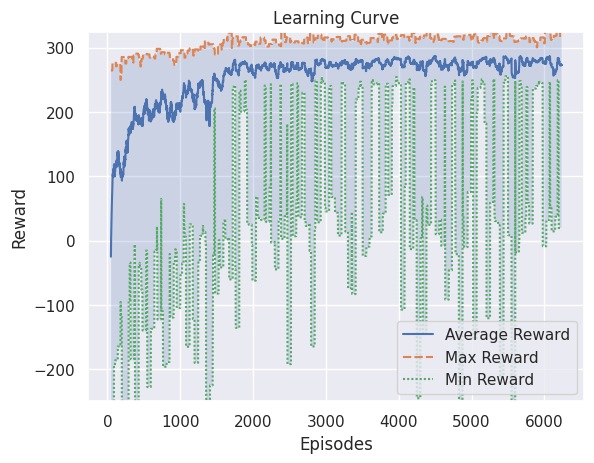

In [ ]:
if __name__ == '__main__':
    start = time.perf_counter()
    env_id = "LunarLander-v2"
    seed = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using: {device}")

    # Logging directory
    model_name = 'Tianshou_ER_DD_DQN'
    log_dir = 'logs/' + model_name + '_' + str(time.strftime('%d_%b_%Y_%H_%M_%S', time.localtime())) + '/'
    writer = SummaryWriter(log_dir=log_dir)
    logger = TensorboardLogger(writer, train_interval=1, update_interval=1)

    # Environment
    env = gym.make(env_id, render_mode="rgb_array")
    train_envs = ts.env.DummyVectorEnv([lambda: gym.make(env_id, render_mode="rgb_array") for _ in range(1)])
    test_envs = ts.env.DummyVectorEnv([lambda: gym.make(env_id, render_mode="rgb_array") for _ in range(1)])

    # Neural network
    Q_param = {"hidden_sizes": [128, 128]}
    V_param = {"hidden_sizes": [128, 128]}
    learning_rate = 1.5e-3
    model_hyperparameters = {'Q_param': Q_param['hidden_sizes'], 'V_param': V_param['hidden_sizes'],
                             'learning_rate': learning_rate}
    state_shape = env.observation_space.shape or env.observation_space.n
    action_shape = env.action_space.shape or env.action_space.n
    net = Net(state_shape, action_shape, dueling_param=(Q_param, V_param), device=device).to(device)
    optim = torch.optim.Adam(net.parameters(), lr=learning_rate)

    # Policy
    policy_hyperparameters = {'discount_factor': 0.99, 'estimation_step': 4, 'target_update_freq': 10,
                              'is_double': True}
    policy = ts.policy.DQNPolicy(net, optim, **policy_hyperparameters)

    # Collectors
    use_prioritised_replay_buffer = False
    prioritized_buffer_hyperparameters = {'total_size': 1_000_000, 'buffer_num': 1, 'alpha': 0.4, 'beta': 0.5}
    if use_prioritised_replay_buffer:
        train_collector = ts.data.Collector(policy, train_envs,
                                            ts.data.PrioritizedVectorReplayBuffer(**prioritized_buffer_hyperparameters),
                                            exploration_noise=True)
    else:
        train_collector = ts.data.Collector(policy, train_envs,
                                            ts.data.ReplayBuffer(size=prioritized_buffer_hyperparameters['total_size']),
                                            exploration_noise=True)
    test_collector = ts.data.Collector(policy, test_envs, exploration_noise=False)

    # Epsilon schedule
    def build_epsilon_schedule(max_epsilon=0.5, min_epsilon=0.0, num_episodes_decay=10000):
        def custom_epsilon_schedule(epoch, env_step):
            decay_step = (max_epsilon - min_epsilon) / num_episodes_decay
            current_epsilon = max_epsilon - env_step * decay_step
            if current_epsilon < 0.0:
                current_epsilon = 0
            policy.set_eps(current_epsilon)

        return custom_epsilon_schedule

    # Test function
    def build_test_fn(num_episodes):
        def custom_test_fn(epoch, env_step):
            print(f"Epoch = {epoch}")

            # Save agent
            torch.save(policy.state_dict(), log_dir + f'dqn_epoch{epoch}.pth')

            # No exploration
            policy.set_eps(0.00)

            # Record agents performance in video
            for episode in range(num_episodes):
                env = ts.env.DummyVectorEnv([lambda: wrappers.RecordVideo(env=gym.make(env_id, render_mode="rgb_array"), video_folder=log_dir + '/videos/epoch_' + str(epoch) + '/video' + str(episode), name_prefix="eval",
                  episode_trigger=lambda x: True) for _ in range(1)])

                # Video
                policy.eval()
                policy.set_eps(0.00)
                collector = ts.data.Collector(policy, env, exploration_noise=True)
                collector.collect(n_episode=1, render=1 / 60)

        return custom_test_fn


    # Training
    trainer_hyperparameters = {'max_epoch': 15, 'step_per_epoch': 100_000, 'step_per_collect': 5,
                               'episode_per_test': 10, 'batch_size': 64}
    epsilon_schedule_hyperparameters = {'max_epsilon': 0.1, 'min_epsilon': 0.0,
                                        'num_episodes_decay': int(trainer_hyperparameters['step_per_epoch'] * 0.1)}
    all_hypeparameters = dict(model_hyperparameters, **policy_hyperparameters, **prioritized_buffer_hyperparameters,
                              **trainer_hyperparameters, **epsilon_schedule_hyperparameters)
    all_hypeparameters['seed'] = seed
    all_hypeparameters['use_prioritised_replay_buffer'] = use_prioritised_replay_buffer
    save_dict_to_file(all_hypeparameters, path=log_dir)
    result = ts.trainer.offpolicy_trainer(policy, train_collector, test_collector, **trainer_hyperparameters,
                                          train_fn=build_epsilon_schedule(**epsilon_schedule_hyperparameters),
                                          test_fn=build_test_fn(num_episodes=4), stop_fn=None, logger=logger)
    print(f'Finished training! Use {result["duration"]}')

    # Learning Curve
    learning_curve_tianshou(log_dir=log_dir, window=50)

    # Record Episode Video
    num_episodes = 10
    for i in range(num_episodes):
        env = ts.env.DummyVectorEnv([lambda: wrappers.RecordVideo(env=gym.make(env_id, render_mode="rgb_array"),
                                                              video_folder=log_dir + '/videos/final_agent/video' + str(i),
                                                              name_prefix="eval",
                                                              episode_trigger=lambda x: True) for _ in range(1)])

        # Video
        policy.eval()
        policy.set_eps(0.00)
        collector = ts.data.Collector(policy, env, exploration_noise=True)
        collector.collect(n_episode=1, render=1 / 60)

    # Save policy
    torch.save(policy.state_dict(), log_dir + 'dqn.pth')

    # Execution Time
    end = time.perf_counter()  # tensorboard --logdir './Box2D/LunarLander/logs'
    print(f"\nExecution time = {end - start:.2f} second(s)")

In [ ]:
# Record Episode Video
num_episodes = 10
for i in range(num_episodes):
    env = ts.env.DummyVectorEnv([lambda: wrappers.RecordVideo(env=gym.make(env_id, render_mode="rgb_array"),
                                                              video_folder=log_dir + '/videos/final_agent/video' + str(i),
                                                              name_prefix="eval",
                                                              episode_trigger=lambda x: True) for _ in range(1)])

    # Video
    policy.eval()
    policy.set_eps(0.00)
    collector = ts.data.Collector(policy, env, exploration_noise=True)
    collector.collect(n_episode=1, render=1 / 60)

# Save policy
torch.save(policy.state_dict(), log_dir + 'dqn.pth')

# Execution Time
end = time.perf_counter()  # tensorboard --logdir './Box2D/LunarLander/logs'
print(f"\nExecution time = {end - start:.2f} second(s)")

Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video0/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video0/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video0/eval-episode-0.mp4


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/monitoring/video_recorder.py:178: UserWarning: WARN: Unable to save last video! Did you call close()?
  logger.warn("Unable to save last video! Did you call close()?")


Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video1/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video1/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video1/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video2/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video2/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video2/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video3/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video3/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video3/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video4/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video4/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video4/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video5/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video5/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video5/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video6/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video6/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video6/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video7/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video7/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video7/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video8/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video8/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video8/eval-episode-0.mp4
Moviepy - Building video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video9/eval-episode-0.mp4.
Moviepy - Writing video /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video9/eval-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/final_agent/video9/eval-episode-0.mp4

Execution time = 12613.52 second(s)


The main part of the Lunar Lander project orchestrates the training process of the reinforcement learning agent to solve the LunarLander-v2 environment. Here's a detailed explanation of each component within the main section:

1. **Setup Environment and Logging**:

  Initializes the Gym environment for LunarLander-v2 and sets up logging directories for storing training data and Tensorboard logging.
2. **Initialize Neural Network and Optimizer**:

  Defines the neural network architecture for the DQN agent and initializes the optimizer for training.
3. **Initialize Policy and Collectors**:

  Configures the DQN policy and sets up data collectors for both training and testing phases.
4. **Define Epsilon Schedule Function**:

  Constructs an epsilon schedule function to adjust the exploration rate during training.
5. **Define Test Function**:

  Defines a function to test the trained agent's performance, save its state, and record evaluation videos.
6. **Training**:

  Sets hyperparameters for training and executes the off-policy training loop using the Tianshou library. It saves hyperparameters to a file for reference.
6. **Generate Learning Curve**:

  Calls the learning_curve_tianshou function to generate and save the learning curve plot based on training data.
7. **Record Episode Videos**:

  Records videos of the final trained agent's performance in multiple episodes and saves them for evaluation.
8. **Save Trained Policy**:

  Saves the trained policy's state dictionary for future use or further analysis.
9. **Print Execution Time**:

  Prints the total execution time of the training process for performance evaluation and monitoring.

## **Results**
If you are unable to access the videos, please click on the link provided to view them on [Google Colab](https://colab.research.google.com/drive/1PSgWgQs8qo1aQdAekZsZNhZURDN0RDCo#scrollTo=eDdapJW_zSDj).

In [ ]:
import imageio
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(video):
    fig = plt.figure(figsize=(3,3))  #Display size specification

    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=17, repeat_delay=1000)

    plt.close()
    return anime

# **Epoch 0, Video 3**

In [ ]:
video = imageio.mimread('/content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_0/video3/eval-episode-0.mp4')  #Loading video
# video = [resize(frame, (400, 600)) for frame in video]    # Size adjustment (if necessary)
HTML(display_video(video).to_html5_video())  #Inline video display in HTML5

# **Epoch 5, Video 3**

In [ ]:
video = imageio.mimread('/content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_5/video3/eval-episode-0.mp4')
HTML(display_video(video).to_html5_video())

# **Epoch 10, video 3**

In [ ]:
video = imageio.mimread('/content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_10/video3/eval-episode-0.mp4')
HTML(display_video(video).to_html5_video())

# **Epoch 13, Video 3**

In [ ]:
video = imageio.mimread('/content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_13/video3/eval-episode-0.mp4')
HTML(display_video(video).to_html5_video())


# **Epoch 15, Video 3**

In [ ]:
video = imageio.mimread('/content/logs/Tianshou_ER_DD_DQN_05_Feb_2024_13_40_33/videos/epoch_15/video3/eval-episode-0.mp4')
HTML(display_video(video).to_html5_video())

## **Conclusion**

The Lunar Lander project demonstrates the application of reinforcement learning techniques to solve the LunarLander-v2 environment. By training an agent using the Tianshou library, the project aims to achieve optimal performance in landing the lunar module safely on the moon's surface. The utilities provided offer functionalities for logging training data, visualizing learning curves, and recording agent performance videos, facilitating comprehensive analysis and evaluation of the trained agent's behavior.